In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig
import sympy as sp

Of interest in such models are points P, C, Q, and T, which refer, respectively,
to the reference point (i.e., where the plunge displacement h is measUred), the center
of mass, the aerodynamic center (i.e., presumed to be the quarter-chord in subsonic
thin-airfoil theory), and the three-quarter-chord (i.e., an important chordwise location in thin-airfoil theory). 

P = reference point (i.e., where the plunge displacement h is measured)

C = the center of mass

Q = the aerodynamic center (i.e., presumed to be the quarter-chord in subsonic thin-airfoil theory)

T = and the three-quarter-chord (i.e., an important chordwise location in thin-airfoil theory)

The dimensionless parameters e and a (i.e., −1 ≤ e ≤ 1
and −1 ≤ a ≤ 1) determine the locations of the points C and P: when these parameters are zero, the points lie on the mid-chord, and when they are positive (negative),
the points lie toward the trailing (leading) edge

xθ = e − a. This so-called static-unbalance parameter is positive when the center
of mass is toward the trailing edge from the reference point.

In [11]:
# Physical parameters to define.
m = 1
I_P = 1.0
k_h = 1.0
k_theta = 1.0
rho_inf = 1.0 # 1.225         # Freestream air density

# Airfoil geometry
a = 0.1#0               # Distance parameter for aerodynamic center
e = 0.1# 0              # Dimensionless offset from the reference point to center of mass
b = 2                   # airfoil semi-chord
b = 139                   # airfoil semi-chord


# Values used for Fig. 5.3 and 5.4
a = -1/5
e = -1/10
mu = 20
r2 = 6/25
r = np.sqrt(r2)
sigma = 2/5
b = 0.5                   # airfoil semi-chord

In [15]:
b = 139                   # airfoil semi-chord


In [3]:
# Physical parameters to define.
m = 1
I_P = 1.0
k_h = 1.0
k_theta = 1.0
rho_inf = 1.225         # Freestream air density

# Values used for Fig. 5.3 and 5.4
a = -1/5
e = -1/10
mu = 20
r2 = 6/25
r = np.sqrt(r2)
sigma = 2/5
b = 0.5                   # airfoil semi-chord


# Airfoil geometry
a = 0.2#0               # Distance parameter for aerodynamic center
e = 0.2# 0              # Dimensionless offset from the reference point to center of mass
b = 0.5                 # airfoil semi-chord

a = -1/5
e = -1/10

In [16]:
# Some variables
w_h = np.sqrt(k_h / m)
w_theta = np.sqrt(k_theta / I_P)

mu = m / (rho_inf * np.pi * b**2) # Mass ratio: mu = m / (rho_inf * pi * b^2)
r2 = I_P / (m * b**2)             # Square of radius of gyration: 
r = np.sqrt(r2)
sigma = w_h / w_theta           # Frequency ratio: 
x_theta = e - a        # Static unbalance: 

the analysis predicts that flutter occurs at a value of V = VF < VD

In [17]:
# eq 3.35 This assumes p = 0
VD = r * np.sqrt(mu / (1 + 2 * a)) # divergence vel. XX Also it's weird that a cant be smaller than -0.5
print("dimensionless divergence speed VD (eq 5.35: " , VD) # XX check this

dimensionless divergence speed VD (eq 5.35:  3.769813262226175e-05


In [6]:
# Simulation Parameters
n_vels = 60
V = np.linspace(0.01, 4, n_vels)  # Reduced velocity range (V = U / (b * w_theta))
U = V * b * w_theta # XX

In [18]:
# Eq 5.32


merge_velocities = [] # storing the places where the ommegas curves merge. # Fig 5.3
separate_velocities = [] # storing the places where the ommegas curves separate. # Fig 5.3
merged = False # initially I assume the two curves are separated

modal_frequencies = np.zeros((n_vels, 2))
modal_damping = np.zeros((n_vels, 2))

vs = []
for i in range(n_vels):

    p = sp.symbols('p') # p is the unknown dimensionless, complex eigenvalue

    M11 = p**2 + sigma**2/V[i]**2
    M12 = x_theta*p**2 + 2/mu
    M21 = x_theta*p**2
    M22 = r2*p**2 + r2/V[i]**2 - 2*(a + 1/2)/mu
    A = sp.Matrix([
        [M11, M12],
        [M21, M22]
    ])
    # A = sp.Matrix([
    #     [p**2 + sigma**2/V[i]**2, x_theta*p**2 + 2/mu],
    #     [x_theta*p**2, r2*p**2 + r2/V[i]**2 - 2*(a + 1/2)/mu]
    # ])

    # Solve the characteristic equation det(A) = 0
    det_A = A.det() # characteristic polynomial
    p_solutions = sp.solve(det_A, p) # by default is solves for det_A = 0
    p_solutions = np.array([complex(x) for x in p_solutions]) * V[i] # Normalizing by the velocity and changing the variable type to make it easier to work with

    # could be more elegant but works
    omegas = [np.abs(p.imag) for p in p_solutions if p.imag >= 0] # there are always 2 complex cojjugate roots. We dont want the +- imaginary part, just the + imaginary
    modal_frequencies[i] = (omegas[0], omegas[1])

    if not merged and ((omegas[0] - omegas[1]) == 0):
        merge_velocities.append(i-1)
        merged = True
    elif merged and ((omegas[0] - omegas[1]) != 0):
        separate_velocities.append(i)
        merged = False
    
    gammas = np.unique([p.real for p in p_solutions])
    if len(gammas) == 2:
        modal_damping[i] = (gammas[0], gammas[1])
    else:
        modal_damping[i] = (gammas[0], gammas[0])

    vs.append(p_solutions * U[i] / b)

    ### append V[i-1]
    # if not merged and ((omegas[0] - omegas[1]) == 0):
    #     if i != 0: merge_velocities.append(i-1)
    #     else: merge_velocities.append(i)
    #     merged = True
    # elif merged and ((omegas[0] - omegas[1]) != 0):
    #     if i!= 0: separate_velocities.append(i-1)
    #     else: separate_velocities.append(i-1)
    #     merged = False

    # lens.append(len(omegas))
    # if len(omegas) == 2:
    #     modal_frequencies[i] = (omegas[0], omegas[1])
    # elif len(omegas) == 1:
    #     modal_frequencies[i] = (omegas[0], omegas[0])
    #     print(i, "''")
    #     if not merged:
    #         diveregence_velocities.append(V[i])
    #         print(i)
    #         merged = True
    # else:
    #     print("----?? \n", p_solutions)
    #     print(V[i])

    

In [8]:
vs[20] / U[20] * b

array([-0.12892558-0.91654901j, -0.12892558+0.91654901j,
        0.12892558-0.91654901j,  0.12892558+0.91654901j])

In [9]:
vs[35]

array([0.-1.86156424j, 0.-1.30572403j, 0.+1.30572403j, 0.+1.86156424j])

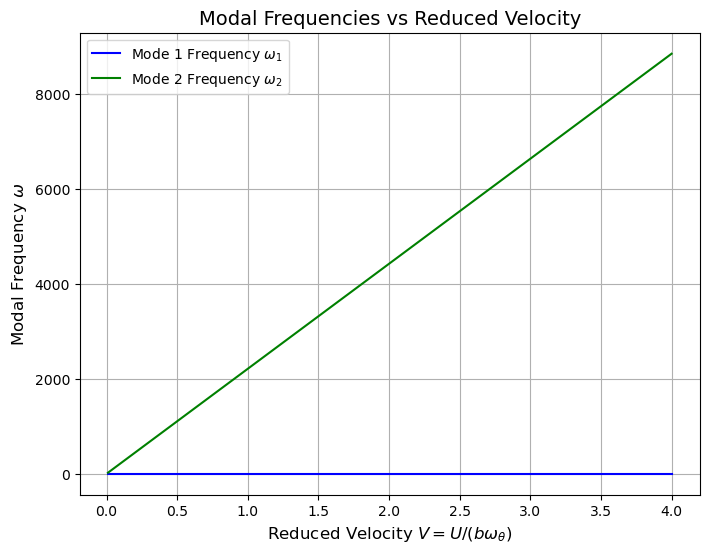

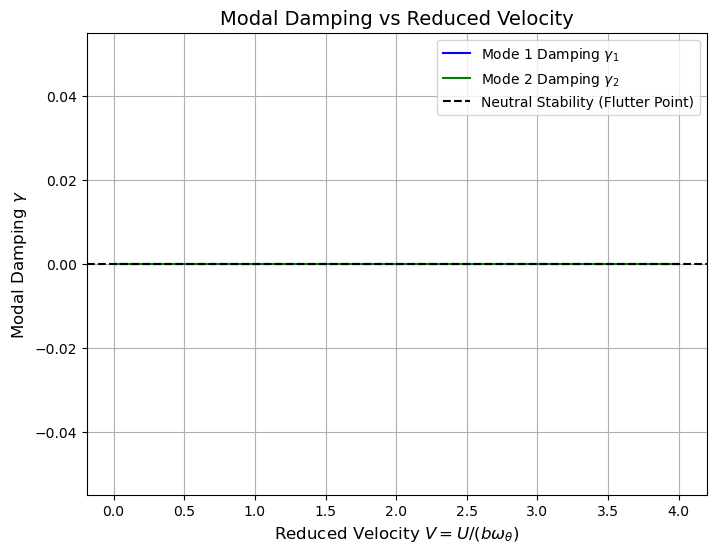

In [19]:
# Plot modal frequencies
plt.figure(figsize=(8, 6))
plt.plot(V, modal_frequencies[:, 0], label=r'Mode 1 Frequency $\omega_1$', color='blue')
plt.plot(V, modal_frequencies[:, 1], label=r'Mode 2 Frequency $\omega_2$', color='green')
# plt.axvline(x=1.843, color='red', linestyle='--', label="Flutter Boundary ($V_F$)")
for vv in merge_velocities: # this is just bc there may be more than one places where it merges.
    plt.axvline(x=V[vv+1], color='red', linestyle='--', label="Flutter Boundary ($V_F$)")
# plt.axvline(x=VD, color='red', linestyle='--', label="Flutter Boundary ($V_F$)") # This would be using the VD we calculate using eq 5.35, but it didnt work well
plt.xlabel(r'Reduced Velocity $V = U / (b \omega_\theta)$', fontsize=12)
plt.ylabel(r'Modal Frequency $\omega$', fontsize=12)
plt.title('Modal Frequencies vs Reduced Velocity', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()

# Plot modal damping
plt.figure(figsize=(8, 6))
plt.plot(V, modal_damping[:, 0], label=r'Mode 1 Damping $\gamma_1$', color='blue')
plt.plot(V, modal_damping[:, 1], label=r'Mode 2 Damping $\gamma_2$', color='green')
plt.axhline(y=0, color='black', linestyle='--', label="Neutral Stability (Flutter Point)")
for vv in merge_velocities: # this is just bc there may be more than one places where it merges.
    plt.axvline(x=V[vv], color='red', linestyle='--', label="Flutter Boundary ($V_F$)") # The 
    # plt.axvline(x=V[vv-1], color='red', linestyle='--', label="Flutter Boundary ($V_F$)") # The 
plt.xlabel(r'Reduced Velocity $V = U / (b \omega_\theta)$', fontsize=12)
plt.ylabel(r'Modal Damping $\gamma$', fontsize=12)
plt.title('Modal Damping vs Reduced Velocity', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()
